In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import r2_score

%matplotlib inline

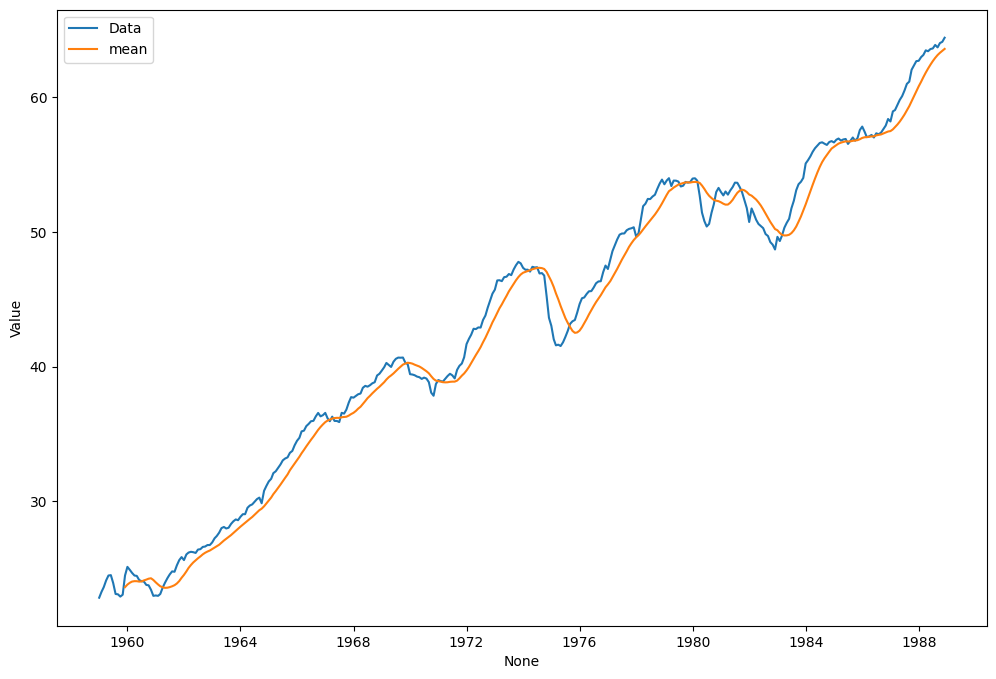

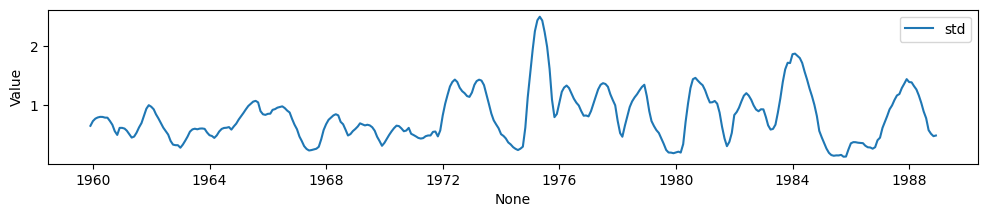

In [ ]:
train_data = pd.read_csv("training.csv")
train_dates = train_data.values[:, 0]
train_dates = pd.to_datetime(train_dates)

plt.subplots(figsize=(12, 8))

sns.lineplot(x=train_dates, y=train_data.values[:, 1], legend=True, label="Data")

rolling_mean = train_data['Value'].rolling(window=12).mean()
sns.lineplot(x=train_dates, y=rolling_mean, legend=True, label="mean")

plt.subplots(figsize=(12, 2))

rolling_std = train_data["Value"].rolling(window=12).std()
sns.lineplot(x=train_dates, y=rolling_std, legend=True, label="std")

plt.show()

Тест Дики-Фуллера: проверка на стационарность временного ряда.

In [ ]:
def IsStationary(data):
  dftest = adfuller(data)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
        '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)' % key] = value
  if dftest[0] > dftest[4]['5%']:
      return 'NO'
  return 'YES'

In [ ]:
IsStationary(train_data["Value"])

'NO'

Временной ряд не стационарен.

Оценка стационарности тренда, сезональности и остатка в аддитивной модели.

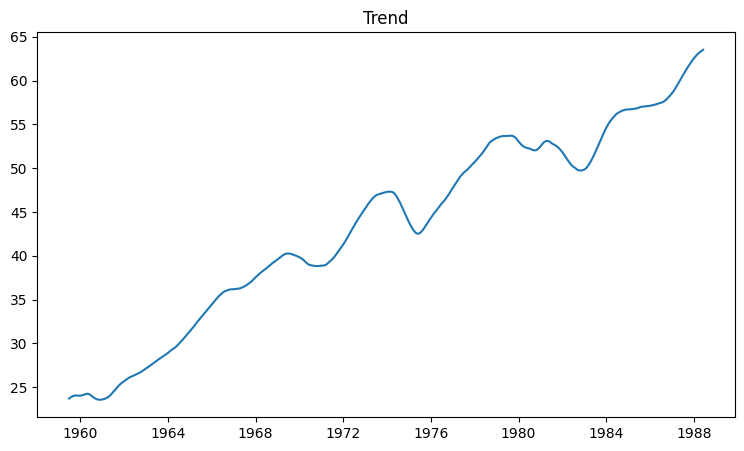

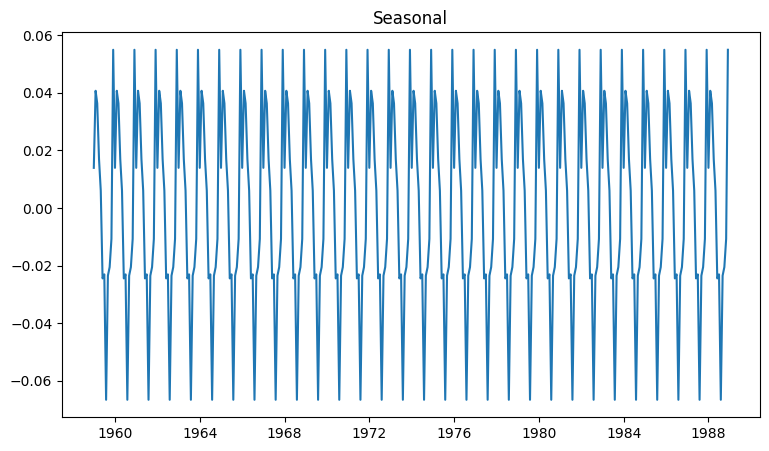

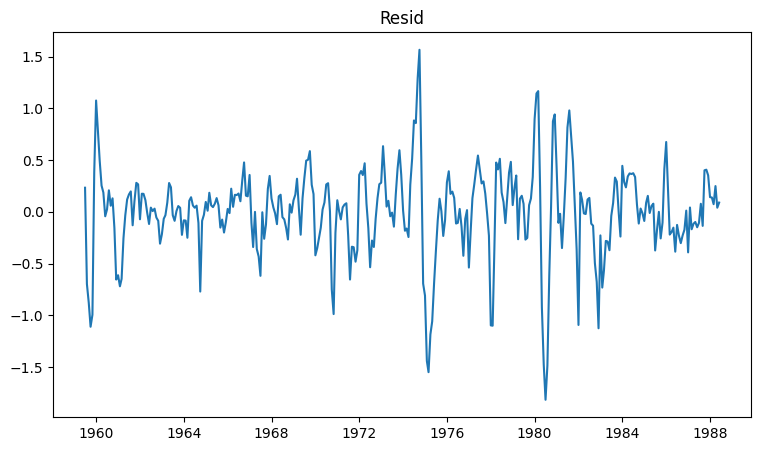

In [ ]:
train_data["Date"] = pd.to_datetime(train_data["Date"])
prepared = train_data.set_index("Date")

decomposed = seasonal_decompose(prepared, model="additive")

trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

def draw(d, t):
  plt.figure(figsize=(9, 5))
  plt.plot(d)
  plt.title(t)
  plt.show()
  print()

draw(trend, "Trend")
draw(seasonal, "Seasonal")
draw(resid, "Resid")

Посмотрев на построенные графики, можно сделать вывод о том, что сезональность нашего ряда 1 год

In [ ]:
trend_notna = trend.dropna(inplace=False)
IsStationary(trend_notna)

'NO'

In [ ]:
seasonal_notna = seasonal.dropna(inplace=False)
IsStationary(seasonal_notna)

'YES'

In [ ]:
resid_notna = resid.dropna(inplace=False)
IsStationary(resid_notna)

'YES'

Оценка стационарности тренда, сезональности и остатка в мультипликативной модели.

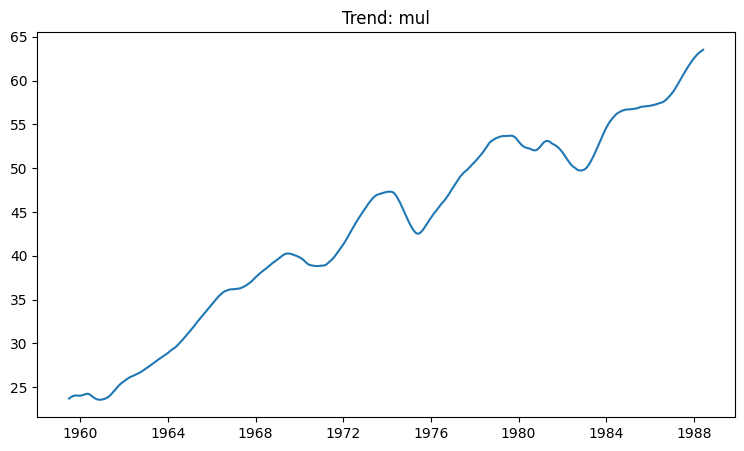

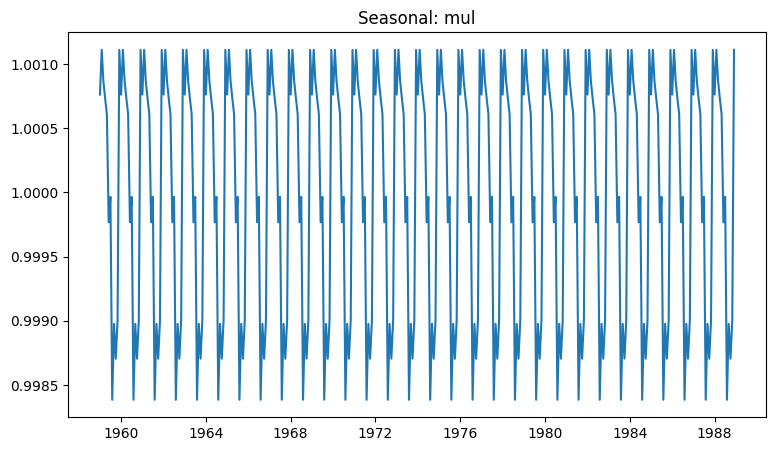

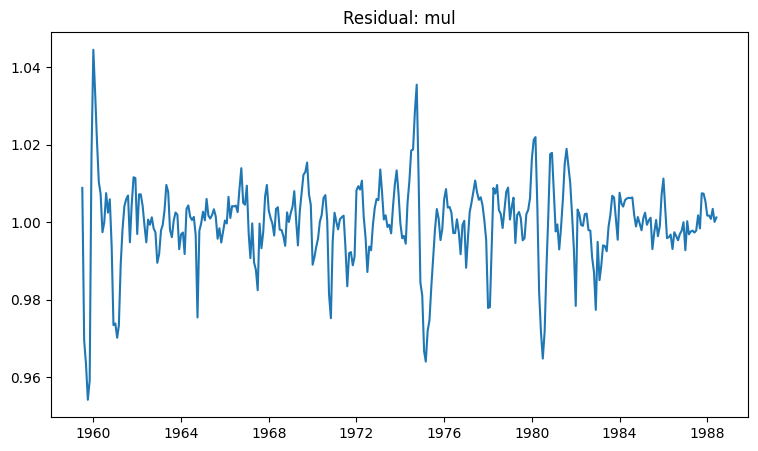

In [ ]:
decomposition = seasonal_decompose(prepared, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

draw(trend, "Trend: mul")
draw(seasonal, "Seasonal: mul")
draw(residual, "Residual: mul")

In [ ]:
trend_notna = trend.dropna(inplace=False)
IsStationary(trend_notna)

'NO'

In [ ]:
seasonal_notna = seasonal.dropna(inplace=False)
IsStationary(seasonal_notna)

'YES'

In [ ]:
resid_notna = resid.dropna(inplace=False)
IsStationary(resid_notna)

'YES'

Таким образом, нестационарность проявляется только в тренде.

Функция получения порядка интегрированности временного ряда:

In [ ]:
def find_k(data):
  k = 0
  while IsStationary(data) == "NO":
    data = data.diff(periods=1).dropna()
    k += 1
  return k

In [ ]:
k = find_k(prepared_data)
print(k)

1


Получили, что после единоразового дифференцирования ряда он стал стационарным. Следовательно, ряд интегрированный порядка $k = 1$.

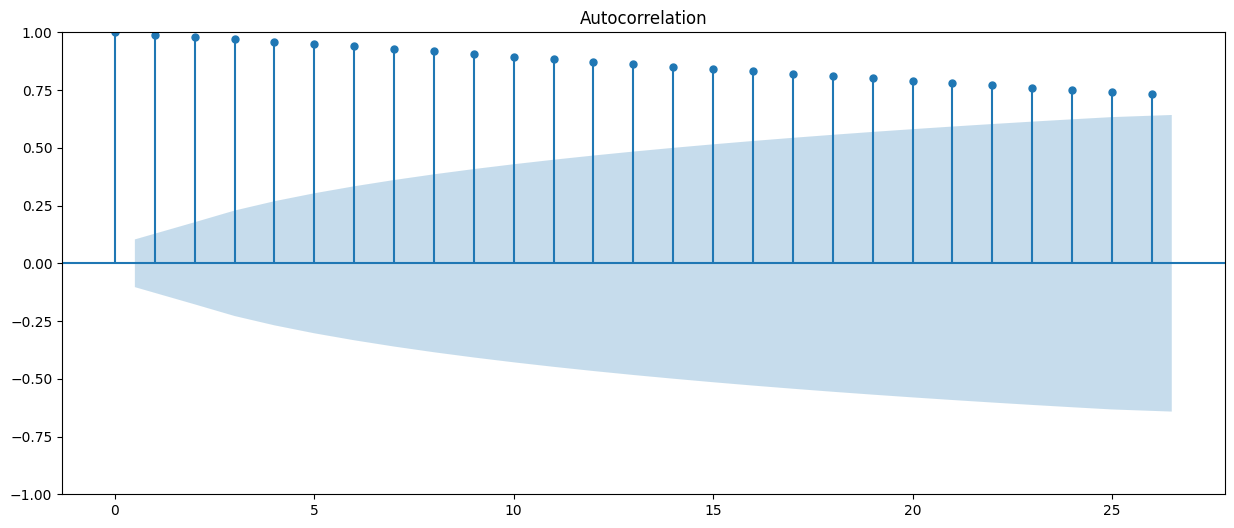

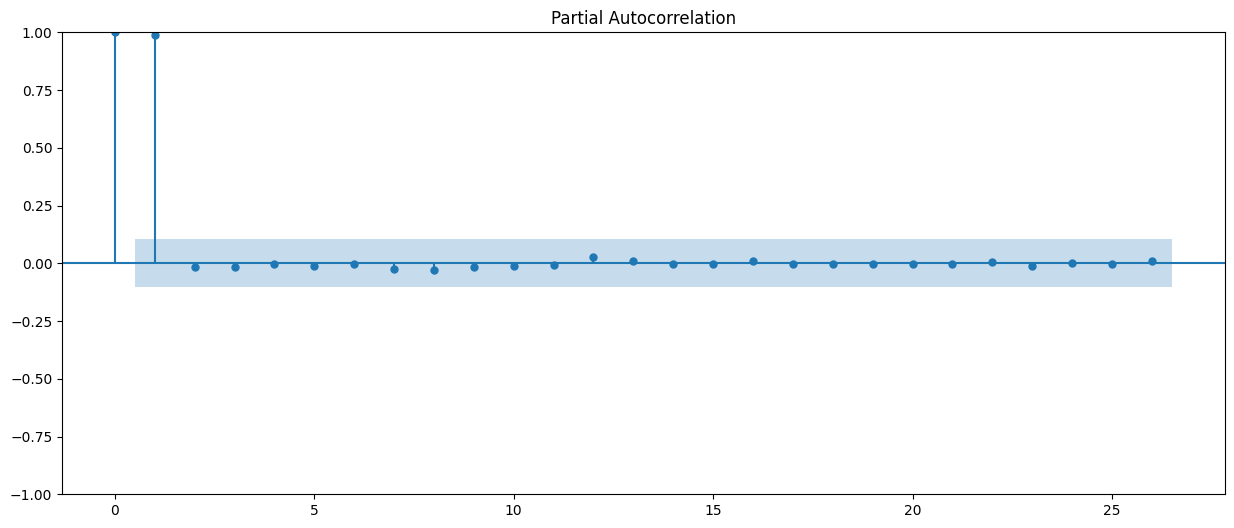

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(prepared.dropna())
plot_pacf(prepared.dropna())
plt.show()

Осуществим перебор параметров по "пиковым" значениям. Функция PACF соответствует параметру $p$, ACF - параметру $q$ модели ARIMA($p, k, q$). $k = 1$ из полученного выше порядка интегрированности ряда:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

params = [(p, k, q) for p in range(2) for q in range(25)]
average_scores = []

for param in params:
    r2_scores = []
    ccv = TimeSeriesSplit(n_splits=3)
    for train_i, test_i in ccv.split(train_data):
        X_train, X_test = prepared.index[train_i], prepared.index[test_i]
        y_train, y_test = prepared.iloc[train_i], prepared.iloc[test_i]
        y_train.index.freq = "MS"
        y_test.index.freq = "MS"

        model = ARIMA(y_train, order=param).fit()
        y_pred = model.predict(start=X_test[0], end=X_test[-1])
        r2_scores.append(r2_score(y_test, y_pred))
    average_scores.append(np.mean(np.array(r2_scores)))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
print(av_scores.index(max(av_scores)))

34


Лучшее значение было получено на наборе (1, 1, 9) - набор с индексом 34.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


-137.71249573181254


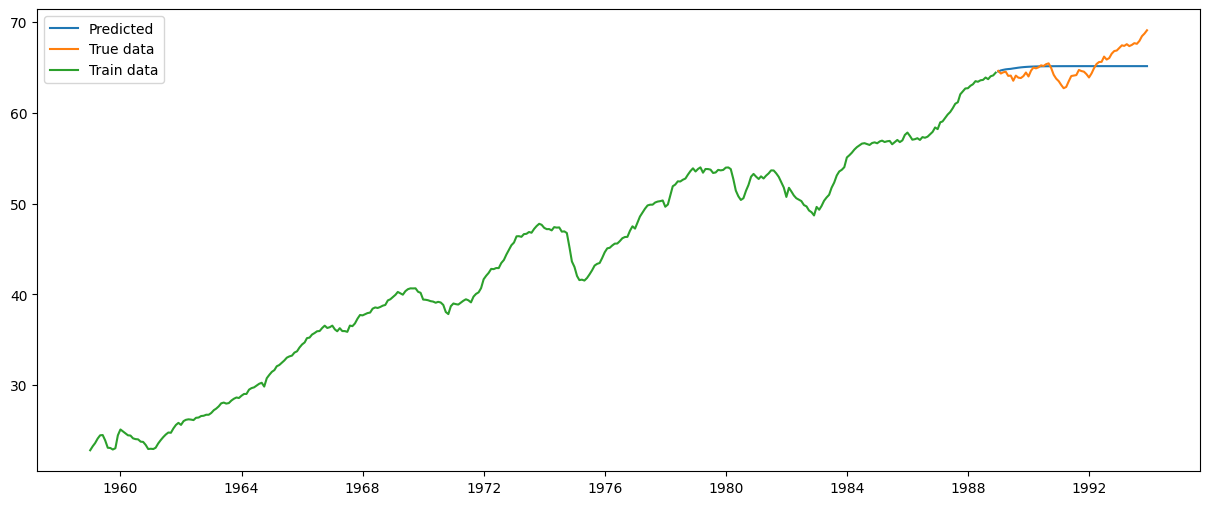

In [ ]:
test_data = pd.read_csv("testing.csv")

test_data['Date'] = pd.to_datetime(test_data['Date'])
dates = train_data.values[:, 0]
dates = pd.to_datetime(dates)

test_dates = test_data.values[:, 0]
test_dates = pd.to_datetime(test_dates)

model = ARIMA(prepared, order=params[av_scores.index(max(av_scores))]).fit()

y_pred = model.predict(start=test_dates[0], end=test_dates[-1])

plt.plot(y_pred, label='Predicted')
plt.plot(test_data['Date'], test_data['Value'], label="True data")
plt.plot(train_data["Date"], train_data["Value"], label="Train data")

print(r2_score(y_pred, test_data['Value']))
plt.legend()
plt.show()

Видно, что модель слишком простая, плохо предсказывает результат, несмотря на то, что мы выбрали наилучшие подобранные параметры.

Учтем теперь нестационарность тренда, добавив параметр trend='t':

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


-1.4389730350527565


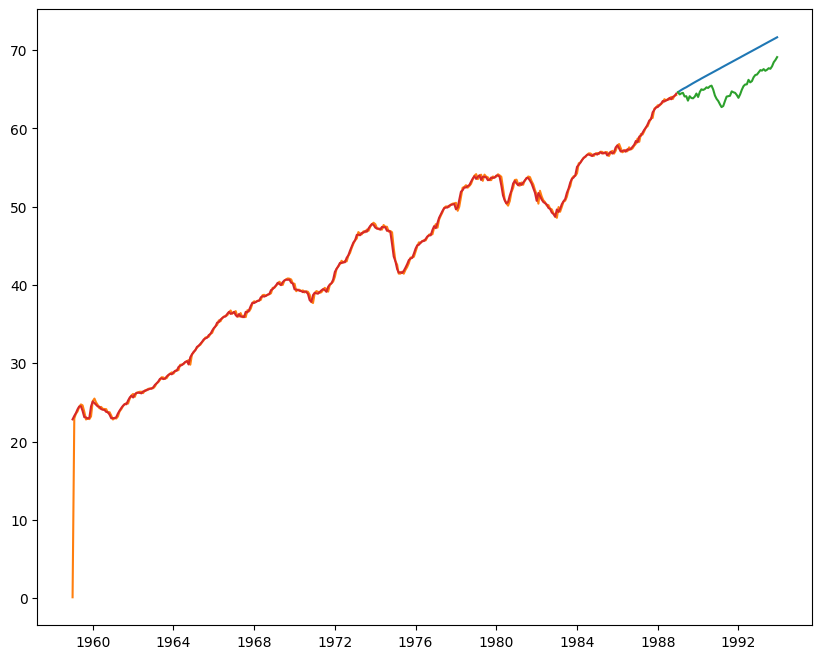

In [ ]:
plt.figure(figsize=(10,8))
model = ARIMA(prepared, order=(1, 1, 9), trend='t').fit(method_kwargs={'maxiter': 100})
y_pred = model.predict(start=test_dates[0], end=test_dates[-1])
plt.plot(y_pred)
plt.plot(model.predict(start=dates[0], end=dates[-1]))
plt.plot(test_data['Date'], test_data['Value'])
plt.plot(train_data['Date'], train_data['Value'])
print(r2_score(y_pred, test_data['Value']))

Стало лучше, поскольку мы увеличили последний параметр, отвечающий за учитываемое число ошибок прогнозирования.

Теперь учтем сезональность ряда, которую мы вывели ранее:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

0.27490333083313034


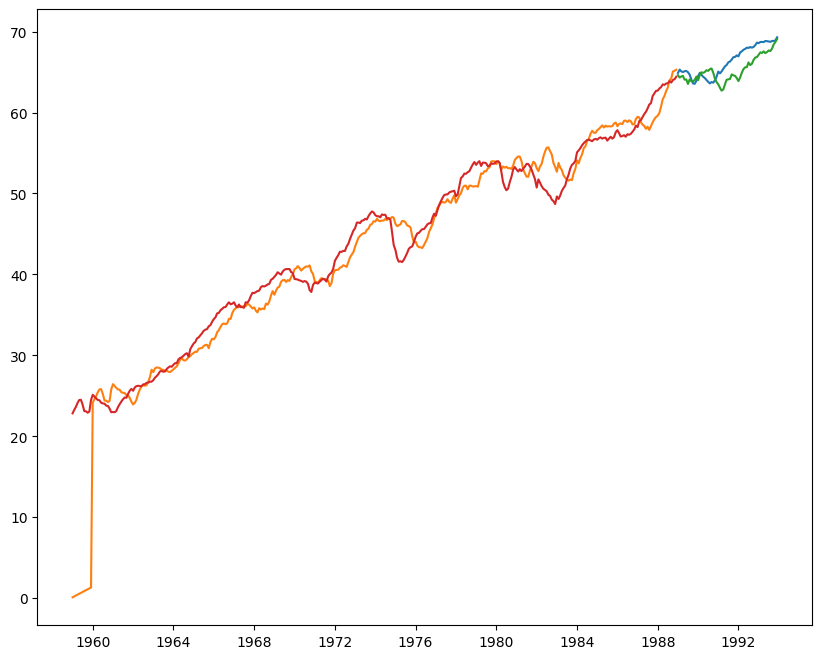

In [ ]:
plt.figure(figsize=(10,8))
model = ARIMA(prepared, seasonal_order=(1, 1, 9, 12), trend='t').fit(method_kwargs={'maxiter': 100})
y_pred = model.predict(start=test_dates[0], end=test_dates[-1])
plt.plot(y_pred)
plt.plot(model.predict(start=dates[0], end=dates[-1]))
plt.plot(test_data['Date'], test_data['Value'])
plt.plot(train_data['Date'], train_data['Value'])
print(r2_score(y_pred, test_data['Value']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum L

0.31659465846028756


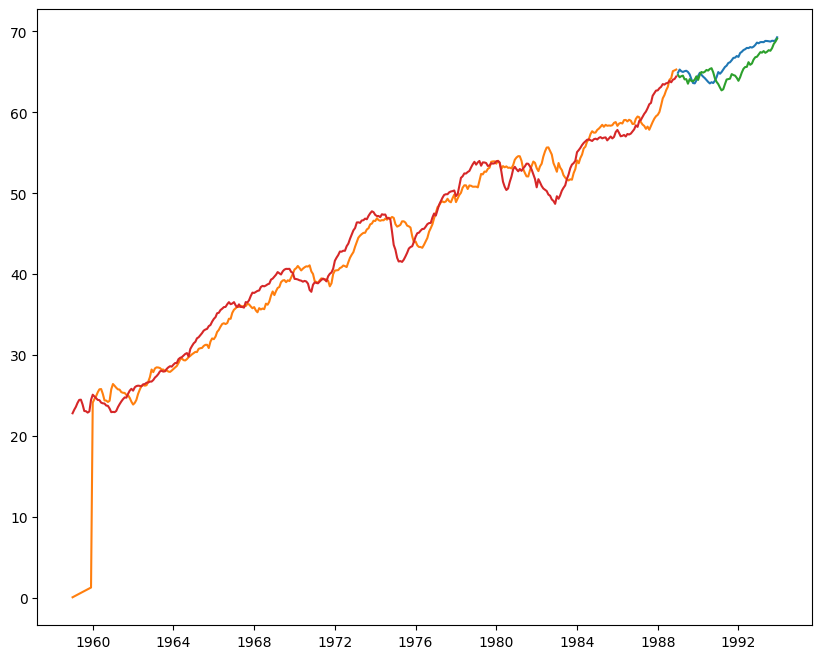

In [ ]:
plt.figure(figsize=(10,8))
model = ARIMA(prepared, seasonal_order=(1, 1, 10, 12), trend='t').fit(method_kwargs={'maxiter': 100})
y_pred = model.predict(start=test_dates[0], end=test_dates[-1])
plt.plot(y_pred)
plt.plot(model.predict(start=dates[0], end=dates[-1]))
plt.plot(test_data['Date'], test_data['Value'])
plt.plot(train_data['Date'], train_data['Value'])
print(r2_score(y_pred, test_data['Value']))

Несмотря на то, что наилучшие подобранные параметры - это (1, 1, 9), мы получили значение r2-score больше на параметрах (1, 1, 10). Скорее всего, это связано с тем, что наилучшие параметры мы нашли без учета сезональности и тренда. Можно также организовать перебор параметров с учетом этих факторов, но это займет намного больше времени, поэтому ограничимся наибольшим полученным "вручную" r2-score. Также отметим, что можно предварительно прологарифмировать данные, но это не сильно скажется на времени перебора (пример кода ниже).

In [ ]:
# k = 1
# params = [(p, k, q, 12) for p in [0, 1, 5, 7, 24] for q in [0, 1, 2, 3, 24]]
# av_scores = []
# for param in params:
#     r2_scores = []
#     ccv = TimeSeriesSplit(n_splits=3)
#     for train_index, test_index in ccv.split(train_data):
#         X_train, X_test = prep_log.index[train_index], prep_log.index[test_index]
#         y_train, y_test = prep_log.iloc[train_index], prep_log.iloc[test_index]
#         y_train.index.freq = "MS"
#         y_test.index.freq = "MS"

#         model = ARIMA(y_train, seasonal_order=param, trend="t").fit(method_kwargs={'maxiter': 100})
#         y_pred = model.predict(start=X_test[0], end=X_test[-1])
#         r2_scores.append(r2_score(y_true=y_test, y_pred=y_pred))
#     av_scores.append(np.mean(np.array(r2_scores)))